# Importation des librairies

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import annotations
from model import CNNModel, ResNet
from cost_matrix import cost_path
import torch.nn.functional as F
import matplotlib.pyplot as plt
from munkres import Munkres
from typing import Optional
from data_loader import *
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
import numpy as np
import random
import pickle
import torch
import time
import math
import os

## Implémentation de l'algorithme MCTS et des fonctions utilitaires

In [2]:
def get_mcts_cost(matrix: np.ndarray, config: dict, max_depth: int, max_iterations: int) -> tuple[list[int], float]:
    """Return the best actions and the cost of the best actions using MCTS."""
    state = np.stack([matrix, np.ones(matrix.shape),
                     np.zeros(matrix.shape)], axis=0)
    actions = []
    for i in range(matrix.shape[0]):
        root = Node(state, config, depth=i)
        mcts = MCTS(root, config, max_depth, max_iterations)
        action = mcts.search()
        actions.append(action)
        state[1][i] = 0
        state[1][:, action] = 0
        state[2][i][action] = 1

    return actions, sum(matrix[i][action] for i, action in enumerate(actions))


def get_untried_actions(state: np.ndarray, depth: int) -> list[int]:
    """Return a list of untried actions."""
    if depth >= state[1].shape[0]:
        return []
    return np.argwhere(state[1][depth] == 1).flatten().tolist()


class Node:

    def __init__(self, state: np.ndarray, config: dict, parent=None, action=None, depth=0):
        self.state = state
        self.config = config
        self.parent = parent
        self.action = action
        self.depth = depth

        self.children: list[Node] = []

        self.visit_count = 0
        self.value = 0

    def is_expanded(self) -> bool:
        """Returns True if the node has children."""
        return len(self.children) > 0

    def select(self) -> Optional[Node]:
        """Return the child with the highest UCB score."""
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child: Node) -> float:
        """Return the UCB score of a child node."""
        if child.visit_count == 0:
            return np.inf
        exploitation = child.value / child.visit_count
        exploration = self.config["exploration_constant"] * \
            np.sqrt(np.log(self.visit_count) / child.visit_count)

        return exploitation + exploration

    def expand(self) -> None:
        """Expand the node by creating all possible children."""
        child = None
        for action in get_untried_actions(self.state, self.depth):
            new_state = self.state.copy()
            new_state[1][self.depth] = 0
            new_state[1][:, action] = 0
            new_state[2][self.depth][action] = 1

            child = Node(new_state, self.config, self, action, self.depth + 1)
            self.children.append(child)

    def backpropagate(self, value: float) -> None:
        """Update the node's value and visit count."""
        self.value += value
        self.visit_count += 1

        if self.parent is not None:
            self.parent.backpropagate(value)


class MCTS:

    def __init__(self, root: Node, config: dict, max_depth: int, max_iterations: int = 1000):
        self.root = root
        self.config = config
        self.max_depth = max_depth
        self.max_iterations = max_iterations

    def search(self) -> int:
        for _ in range(self.max_iterations):
            node = self.select_node()
            value = self.rollout(node)
            node.backpropagate(value)

        best_action = None
        best_value = -np.inf
        for child in self.root.children:
            if child.visit_count > best_value:
                best_action = child.action
                best_value = child.visit_count
        if best_action is None:
            raise ValueError("No best action found.")
        return int(best_action)

    def select_node(self) -> Node:
        """Select a node to expand."""
        node = self.root
        while node.is_expanded():
            node = node.select()
            if node is None:
                raise ValueError("Selecting a childless node.")
        if not node.is_expanded():
            node.expand()
        return node

    def rollout(self, node: Node) -> float:
        """Simulate a game from the given node."""
        state = node.state.copy()
        depth = node.depth
        while depth < self.max_depth:
            actions = get_untried_actions(state, depth)
            if len(actions) == 1:
                action = actions[0]
            elif self.config["rollout_mode"] == "random":
                action = random.choice(actions)
            else:
                actions_values = [state[0][depth][action]
                                  for action in actions]
                total_value = sum(actions_values)
                if total_value == 0:
                    action = random.choice(actions)
                else:
                    action_probs = [abs((value - total_value) ** 2)
                                    for value in actions_values]
                    normalized_probs = [prob / sum(action_probs)
                                        for prob in action_probs]
                    action = random.choices(actions, normalized_probs)[0]

            state[1][depth] = 0
            state[1][:, action] = 0
            state[2][depth][action] = 1
            depth += 1
        return self.evaluate(state)

    def evaluate(self, state: np.ndarray) -> float:
        """Evaluate the given state."""
        return 1 - np.multiply(state[0], state[2]).sum() / state[0].sum()

## Test de l'algorithme MCTS sur le problème du LSAP

In [3]:
mcts_config = {
    "exploration_constant": 0.1,
    "rollout_mode": "other"
}

# Création d'une matrice aléatoire
matrix_size = 10
matrix = np.random.randint(1, 100, (matrix_size, matrix_size))

# Algorithme MCTS
actions, cost = get_mcts_cost(matrix, mcts_config, matrix_size, 1000)
print(f"Random matrix:\n{matrix}")
print(f"Nombre de possibilitées pour une matrice de taille {matrix_size}x{matrix_size} : {math.factorial(matrix_size):_}")
print(f"MCST actions: {actions}")
print(f"MCTS cost: {cost}")

# Algorithme hongrois
m = Munkres()
indexes = m.compute(matrix.copy().tolist())
cost = 0
for row, column in indexes:
    value = matrix[row][column]
    cost += value
print(f"Hungarian actions: {[column for row, column in indexes]}")
print(f"Hungarian cost: {cost}")

Random matrix:
[[ 7 50 86 19 60 18 26 20 26 85]
 [29 69 98 93 12  3 96 25 95  3]
 [62 55  4 72 77 53 50 29  9 54]
 [82 81 92 21 54 22 19 64 79 23]
 [98 17 86 55 55 68 72 57 86 99]
 [94  4  8 84 43 38 73 23 70 87]
 [46 74 99 78 64 55 80 85 63 19]
 [97 75  8  9 29  1 48 16 32 12]
 [62 20 64 96 32 66  3 13  9 83]
 [41 79 32 19 91 70  5 69 44 35]]
Nombre de possibilitées pour une matrice de taille 10x10 : 3_628_800
MCST actions: [0, 4, 8, 3, 1, 2, 9, 5, 7, 6]
MCTS cost: 112
Hungarian actions: [0, 4, 8, 3, 1, 2, 9, 5, 7, 6]
Hungarian cost: 112


## Test de l'algorithme MCTS sur une matrice de cout

Nombre de données: 313600


100%|██████████| 1000/1000 [08:58<00:00,  1.86it/s]


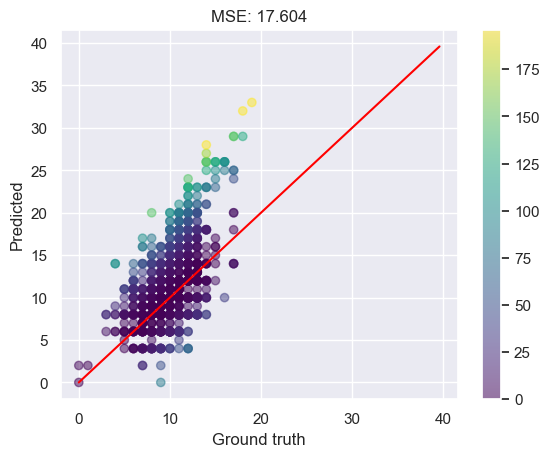

In [6]:
with open("processed/AIDS_train.pkl", "rb") as file:
    data = pickle.load(file)

result = []
print(f"Nombre de données: {data.shape[0]}")
for i in tqdm(range(data.shape[0])[:1000]):
    g1 = data.iloc[i]["g1"]
    g2 = data.iloc[i]["g2"]

    data_row = data.iloc[i]
    cost_matrix = np.array(data_row["cost_matrix"])
    # Compute the cost with the MCTS algorithm
    actions, cost = get_mcts_cost(cost_matrix, mcts_config, cost_matrix.shape[0], 100)
    indexes = list(enumerate(actions))
    estimated_ged = cost_path(g1, g2, indexes, COST)
    result.append((cost, estimated_ged, data_row["ged"]))

# Compute the MSE
result = np.array(result)
mse = np.mean((result[:, 0] - result[:, 2]) ** 2)

# Plot the result
sns.set_theme()
plt.scatter(result[:, 2], result[:, 0], c=(result[:, 0] - result[:, 2]) ** 2, cmap="viridis", alpha=0.5)
plt.colorbar()
plt.plot([0, max(result[:, 0])*1.2], [0, max(result[:, 0])*1.2], color="red")
plt.xlabel("Ground truth")
plt.ylabel("Predicted")
plt.title(f"MSE: {mse}")
plt.show()

## Benchmark de l'algorithme MCTS sur le problème du LSAP contre l'algorithme hongrois

In [12]:
mcts_config = {
    "exploration_constant": 0.1,
    "rollout_mode": "other"
}

simulation_number = 100
mcts_simulation_number = 1000
matrix_size = 10

mcts_costs = []
hungarian_costs = []
mcts_times = []
hungarian_times = []


for _ in tqdm(range(simulation_number)):
    matrix = np.random.randint(1, 20, (matrix_size, matrix_size))

    start = time.time()
    actions, cost = get_mcts_cost(matrix, mcts_config, matrix_size, mcts_simulation_number)
    mcts_times.append(time.time() - start)
    mcts_costs.append(cost)

    start = time.time()
    indexes = m.compute(matrix.copy().tolist())
    cost = 0
    for row, column in indexes:
        value = matrix[row][column]
        cost += value
    hungarian_times.append(time.time() - start)
    hungarian_costs.append(cost)

print(f"Nombre de possibilitées pour une matrice de taille {matrix_size}x{matrix_size} : {math.factorial(matrix_size):_}")

print(f"MCTS cost: {np.mean(mcts_costs):.3f}, time: {np.mean(mcts_times):.5f}s")
print(f"Hungarian cost: {np.mean(hungarian_costs):.3f}, time: {np.mean(hungarian_times):.5f}s")

  2%|▏         | 2/100 [00:02<02:24,  1.47s/it]


KeyboardInterrupt: 

## Impacts des paramètres de l'algorithme MCTS sur la qualité de la solution

### Paramètre de la constante d'exploration

100%|██████████| 10/10 [01:54<00:00, 11.49s/it]


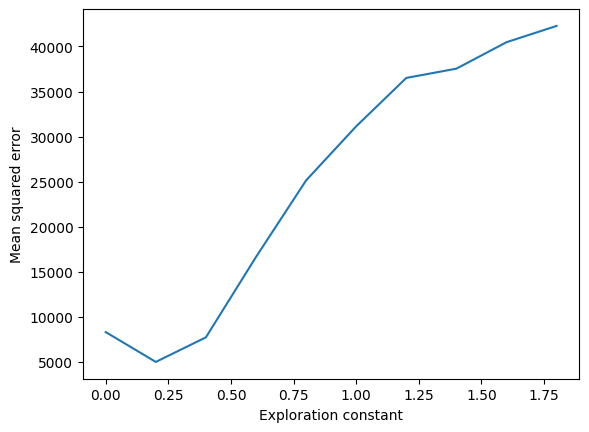

In [21]:
simulation_number = 100
mcts_simulation_number = 100
matrix_size = 10

errors = []
for c in tqdm(np.arange(0, 2, 0.2)):
    config = {
        "exploration_constant": c,
        "rollout_mode": "other"
    }
    mstc_scores = []
    munkres_scores = []
    for _ in range(simulation_number):
        random_matrix = np.random.randint(1, 100, (matrix_size, matrix_size))
        _, mcts_cost = get_mcts_cost(random_matrix, config, matrix_size, mcts_simulation_number)
        mstc_scores.append(mcts_cost)

        m = Munkres()
        indexes = m.compute(random_matrix.copy().tolist())
        cost = 0
        for row, column in indexes:
            value = random_matrix[row][column]
            cost += value
        munkres_scores.append(cost)

    errors.append(np.mean((np.array(mstc_scores) - np.array(munkres_scores)) ** 2))

plt.plot(np.arange(0, 2, 0.2), errors)
plt.xlabel("Exploration constant")
plt.ylabel("Mean squared error")
plt.show()

### Paramètre du nombre de simulations

100%|██████████| 5/5 [04:43<00:00, 56.76s/it]


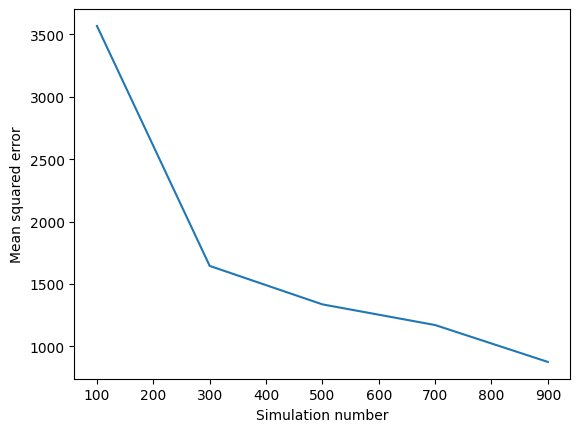

In [22]:
simulation_number = 100
mcts_simulation_number = 100
matrix_size = 10

config = {
    "exploration_constant": 0.1,
    "rollout_mode": "other"
}

errors = []
for exploration_number in tqdm(range(100, 1000, 200)):

    mstc_scores = []
    munkres_scores = []
    for _ in range(simulation_number):
        random_matrix = np.random.randint(1, 100, (matrix_size, matrix_size))
        _, mcts_cost = get_mcts_cost(
            random_matrix, config, matrix_size, exploration_number
        )
        mstc_scores.append(mcts_cost)

        m = Munkres()
        indexes = m.compute(random_matrix.copy().tolist())
        cost = 0
        for row, column in indexes:
            value = random_matrix[row][column]
            cost += value
        munkres_scores.append(cost)

    errors.append(
        np.mean((np.array(mstc_scores) - np.array(munkres_scores)) ** 2))

plt.plot(range(100, 1000, 200), errors)
plt.xlabel("Simulation number")
plt.ylabel("Mean squared error")
plt.show()

## Création du modèle de prédiction

### Fonction de création des données d'entraînement

In [5]:
from data_generation import generate_datas, process_matrix


size = 5
random_matrix = np.random.randint(1, 100, (size, size)).astype(np.float32)
print(f"Random matrix:\n{random_matrix}")
print(f"Processed matrix:\n{process_matrix(random_matrix, size)}")

Random matrix:
[[20. 73. 58. 65. 86.]
 [71. 48. 94. 70. 33.]
 [49. 60. 45.  6. 67.]
 [ 5. 31. 71. 13.  8.]
 [50. 21. 44. 57. 54.]]
Processed matrix:
[[0.27 0.18 0.2  0.19 0.16]
 [0.19 0.22 0.15 0.19 0.25]
 [0.19 0.17 0.2  0.29 0.15]
 [0.27 0.17 0.06 0.24 0.26]
 [0.19 0.26 0.2  0.17 0.18]]


### Entrainement du modèle

In [38]:
size = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(
    state_size=size**2,
    input_size=2,
    num_hidden=64
).to(device)

train_states, train_values = generate_datas(10000, size)
print(f"Train states shape: {train_states.shape}, train values shape: {train_values.shape}")

# Create a dataset and a dataloader
dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_states, dtype=torch.float32),
    torch.tensor(train_values, dtype=torch.float32)
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Create a loss function and an optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    running_loss = 0
    for states, values in dataloader:
        optimizer.zero_grad()
        states = states.to(device)
        outputs = model(states)
        values = values.unsqueeze(1)
        values = torch.cat([1 - values, values], dim=1)
        values = values.to(device)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, loss: {running_loss / len(dataloader) * 10:.2f}")

    test_states, test_values = generate_datas(100, size)
    test_states = torch.tensor(test_states, dtype=torch.float32).to(device)
    outputs = model(test_states)
    values = test_values
    values = values.reshape(-1, 1)
    values = np.concatenate([1 - values, values], axis=1)
    values = torch.tensor(values, dtype=torch.float32).to(device)
    loss = criterion(outputs, values)
    print(f"Test loss: {loss.item() * 10:.2f}")

Train states shape: (200000, 2, 10, 10), train values shape: (200000,)
Epoch 1, loss: 1.34
Test loss: 0.49
Epoch 2, loss: 0.51
Test loss: 0.48
Epoch 3, loss: 0.46
Test loss: 0.48
Epoch 4, loss: 0.42
Test loss: 0.47
Epoch 5, loss: 0.40
Test loss: 0.58
Epoch 6, loss: 0.38
Test loss: 0.39
Epoch 7, loss: 0.37
Test loss: 0.41
Epoch 8, loss: 0.36
Test loss: 0.46
Epoch 9, loss: 0.34
Test loss: 0.39
Epoch 10, loss: 0.34
Test loss: 0.40


In [122]:
size = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(
    state_size=size**2,
    input_size=2,
    num_resBlocks=4,
    num_hidden=64
).to(device)

train_states, train_values = generate_datas(10000, size)
print(f"Train states shape: {train_states.shape}, train values shape: {train_values.shape}")

# Create a dataset and a dataloader
dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_states, dtype=torch.float32),
    torch.tensor(train_values, dtype=torch.float32)
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Create a loss function and an optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    running_loss = 0
    for states, values in dataloader:
        optimizer.zero_grad()
        states = states.to(device)
        outputs = model(states)
        values = values.unsqueeze(1)
        values = torch.cat([1 - values, values], dim=1)
        values = values.to(device)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, loss: {running_loss / len(dataloader) * 10:.2f}")

    test_states, test_values = generate_datas(100, size)
    test_states = torch.tensor(test_states, dtype=torch.float32).to(device)
    outputs = model(test_states)
    values = test_values
    values = values.reshape(-1, 1)
    values = np.concatenate([1 - values, values], axis=1)
    values = torch.tensor(values, dtype=torch.float32).to(device)
    loss = criterion(outputs, values)
    print(f"Test loss: {loss.item() * 10:.2f}")

Train states shape: (200000, 2, 10, 10), train values shape: (200000,)
Epoch 1, loss: 0.66
Test loss: 0.21
Epoch 2, loss: 0.28
Test loss: 0.29
Epoch 3, loss: 0.22
Test loss: 0.26
Epoch 4, loss: 0.18
Test loss: 0.18
Epoch 5, loss: 0.16
Test loss: 0.20
Epoch 6, loss: 0.14
Test loss: 0.20
Epoch 7, loss: 0.12
Test loss: 0.14
Epoch 8, loss: 0.11
Test loss: 0.20
Epoch 9, loss: 0.09
Test loss: 0.16
Epoch 10, loss: 0.08
Test loss: 0.18


### Test du modèle

In [209]:
good = 0
model.eval()
stage = 1
for _ in range(100):
    test_states, test_values = generate_datas(1, size)
    outputs = model(torch.tensor(test_states[-1:], dtype=torch.float32).to(device))
    if np.argmax(outputs.cpu().detach().numpy()) == test_values[-stage]:
        good += 1

print(good)

87


## Modification de l'algorithme MCTS pour utiliser le modèle de prédiction

In [210]:
def get_untried_actions(state: np.ndarray, depth: int) -> list[int]:
    """Return a list of untried actions."""
    if depth >= state[1].shape[0]:
        return []
    return np.argwhere(state[1][depth] == 1).flatten().tolist()


class Node:

    def __init__(self, state: np.ndarray, config: dict, parent=None, action=None, depth=0):
        self.state = state
        self.config = config
        self.parent = parent
        self.action = action
        self.depth = depth

        self.children: list[Node] = []

        self.visit_count = 0
        self.value = 0

    def is_expanded(self) -> bool:
        """Returns True if the node has children."""
        return len(self.children) > 0

    def select(self) -> Optional[Node]:
        """Return the child with the highest UCB score."""
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child: Node) -> float:
        """Return the UCB score of a child node."""
        if child.visit_count == 0:
            return np.inf
        exploitation = child.value / child.visit_count
        exploration = self.config["exploration_constant"] * \
            np.sqrt(np.log(self.visit_count) / child.visit_count)

        return exploitation + exploration

    def expand(self) -> None:
        """Expand the node by creating all possible children."""
        child = None
        for action in get_untried_actions(self.state, self.depth):
            new_state = self.state.copy()
            new_state[1][self.depth] = 0
            new_state[1][:, action] = 0
            new_state[2][self.depth][action] = 1

            child = Node(new_state, self.config, self, action, self.depth + 1)
            self.children.append(child)

    def backpropagate(self, value: float) -> None:
        """Update the node's value and visit count."""
        self.value += value
        self.visit_count += 1

        if self.parent is not None:
            self.parent.backpropagate(value)


class MCTS:

    def __init__(
        self, root: Node, config: dict, max_depth: int,
        model: nn.Module, max_iterations: int = 1000
    ) -> None:
        self.root = root
        self.config = config
        self.max_depth = max_depth
        self.model = model
        self.max_iterations = max_iterations
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )

    def search(self) -> int:
        for _ in range(self.max_iterations):
            node = self.select_node()
            value = self.rollout(node)
            node.backpropagate(value)

        best_action = None
        best_value = -np.inf
        for child in self.root.children:
            if child.visit_count > best_value:
                best_action = child.action
                best_value = child.visit_count
        if best_action is None:
            raise ValueError("No best action found.")
        return int(best_action)

    def select_node(self) -> Node:
        """Select a node to expand."""
        node = self.root
        while node.is_expanded():
            node = node.select()
            if node is None:
                raise ValueError("Selecting a childless node.")
        if not node.is_expanded():
            node.expand()
        return node

    @torch.no_grad()
    def rollout(self, node: Node) -> float:
        """Simulate a game from the given node."""
        state = node.state.copy()
        model_matrix = process_matrix(state[0], state[0].shape[0])
        
        model_state = np.stack([model_matrix, state[2]], axis=0)
        model_state = torch.tensor(model_state, dtype=torch.float32).unsqueeze(0).to(self.device)
        output = self.model(model_state).argmax().item() * 2 - 1
        print(f"Output: {output}")
        return output


def get_mcts_cost(matrix: np.ndarray, config: dict, max_depth: int, max_iterations: int, model: nn.Module) -> tuple[list[int], float]:
    """Return the best actions and the cost of the best actions using MCTS."""
    state = np.stack([matrix, np.ones(matrix.shape),
                     np.zeros(matrix.shape)], axis=0)
    actions = []
    for i in range(matrix.shape[0]):
        root = Node(state, config, depth=i)
        mcts = MCTS(root, config, max_depth, model, max_iterations)
        action = mcts.search()
        actions.append(action)
        state[1][i] = 0
        state[1][:, action] = 0
        state[2][i][action] = 1

    return actions, sum(matrix[i][action] for i, action in enumerate(actions))


In [211]:
matrix_size = 10

mcts_config = {
    "exploration_constant": 0.1,
    "rollout_mode": "other"
}

mcts_simulation_number = 1000

random_matrix = np.random.randint(1, 100, (matrix_size, matrix_size))
_, mcts_cost = get_mcts_cost(
    random_matrix, mcts_config, matrix_size, mcts_simulation_number, model
)

print(f"MCTS cost: {mcts_cost:.3f}")

# Algorithme hongrois
m = Munkres()
indexes = m.compute(random_matrix.copy().tolist())
cost = 0
for row, column in indexes:
    value = random_matrix[row][column]
    cost += value
print(f"Hungarian cost: {cost:.3f}")

Output: 1
Output: -1
Output: 1
Output: -1
Output: 1
Output: -1
Output: -1
Output: -1
Output: -1
Output: 1
Output: -1
Output: -1
Output: 1
Output: 1
Output: -1
Output: -1
Output: 1
Output: -1
Output: 1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: 1
Output: 1
Output: 1
Output: -1
Output: 1
Output: 1
Output: 1
Output: 1
Output: 1
Output: 1
Output: -1
Output: -1
Output: 1
Output: 1
Output: -1
Output: 1
Output: -1
Output: 1
Output: 1
Output: 1
Output: -1
Output: 1
Output: 1
Output: 1
Output: 1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: 1
Output: 1
Output: -1
Output: 1
Output: 1
Output: 1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: 1
Output: 1
Output: -1
Output: 1
Output: 1
Output: 1
Output: 1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: -1
Output: 1
Output: -1
Output: 1
Output: 1
Output:

In [201]:
matrix_size = 10
matrix = np.random.randint(1, 100, (matrix_size, matrix_size))
model.eval()

root_state = np.stack([matrix, np.ones(matrix.shape), np.zeros(matrix.shape)], axis=0)
root_state[2][0][0] = 1
print(root_state)

model_matrix = process_matrix(root_state[0], root_state[0].shape[0])
        
model_state = np.stack([model_matrix, root_state[2].astype(np.int32)], axis=0)
model_state = torch.tensor(model_state, dtype=torch.float32).unsqueeze(0).to(device)
model_value = model(model_state)
print(model_value)

# munkres
m = Munkres()
indexes = m.compute(matrix.copy().tolist())
cost_matrix = np.zeros(matrix.shape)
for row, column in indexes:
    cost_matrix[row][column] = 1
print(cost_matrix)

solution = np.zeros((matrix_size, matrix_size))
random_permutation = np.random.permutation(matrix_size)

is_valid = True
for k in range(np.random.randint(1, size + 1)):
    solution[k][random_permutation[k]] = 1
    if cost_matrix[k][random_permutation[k]] != 1:
        is_valid = False
print(is_valid)


[[[82. 41. 85.  8. 46.  2. 63. 12. 50. 24.]
  [95. 92. 63. 31. 85. 64. 33. 44. 84. 12.]
  [35. 16. 41. 24. 21. 19. 93. 32. 38. 91.]
  [67. 48. 69. 73. 73. 38. 81. 53. 72. 19.]
  [70. 28. 77. 55. 96. 22. 66. 67.  9. 76.]
  [68. 96. 56. 99. 62.  8.  5. 21.  3. 74.]
  [61. 18. 18. 18. 43. 60. 73. 98. 47. 63.]
  [79. 38. 51. 30. 42. 25. 38. 46. 33. 40.]
  [37. 70. 23. 76. 22. 73. 18. 94. 56. 77.]
  [93. 12. 65. 68.  1. 83. 81. 14. 82. 15.]]

 [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]

 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  